In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deathtrooper/multichannel-glaucoma-benchmark-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/glucoam/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10


In [61]:
import pandas as pd

import os

In [62]:
os.listdir(path)

['optic-cup',
 'spectral-oct-cup',
 'metadata - standardized.csv',
 'vessel-artery',
 'spectral-oct',
 'spectral-oct-disc',
 'full-fundus',
 'optic-disc',
 'blood-vessel',
 'vessel-vein']

In [63]:
df = pd.read_csv(f"{path}/metadata - standardized.csv")

In [64]:
from utils.main import check_file

In [65]:
import cv2

In [152]:
images = []
mask = []

IMG_SIZE = 256

for item in df['names']:
    if not check_file(f"./data/cropped/optic-cup/{item}.png"):
        continue
    
    img = cv2.imread(f"./data/cropped/full-fundus/{item}.png")
    r_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    mask_img = cv2.imread(f"./data/cropped/optic-cup/{item}.png")
    r_mask_img = cv2.resize(mask_img, (IMG_SIZE, IMG_SIZE))

    images.append(r_img)
    mask.append(r_mask_img)

In [153]:
print("Size of Images : ", len(images))
print("Size of Optic cup : ", len(mask))

Size of Images :  2860
Size of Optic cup :  2860


In [154]:
import numpy as np

In [155]:
images = np.array(images)
mask = np.array(mask)

In [156]:
e_images = np.expand_dims(images, axis=-1)
e_mask = np.expand_dims(mask, axis=-1)

In [157]:
normalize_images = e_images.astype("float32") / 255.0
noramalize_mask = e_mask.astype("float32") / 255.0

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, Y_train, Y_test = train_test_split(normalize_images, noramalize_mask, train_size=0.01)

In [160]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [161]:
import segmentation_models as sm

In [162]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [163]:
model = sm.Unet(
    backbone_name="resnet34",
    encoder_weights="imagenet",
    classes=1,
    activation="sigmoid"
)

In [164]:
loss = sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]

In [165]:
import tensorflow as tf

In [166]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss,
    metrics=metrics
)

In [167]:
history = model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=100,
    validation_split=0.1
)

Epoch 1/100


2025-11-19 15:23:59.723248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7/7 [==============================] - 10s 346ms/step - loss: 0.7528 - iou_score: 0.1347 - f1-score: 0.2353 - accuracy: 0.2511 - val_loss: 0.7822 - val_iou_score: 0.1181 - val_f1-score: 0.2113 - val_accuracy: 0.1057
Epoch 2/100
7/7 [==============================] - 1s 144ms/step - loss: 0.7014 - iou_score: 0.1792 - f1-score: 0.3008 - accuracy: 0.3808 - val_loss: 0.7575 - val_iou_score: 0.1183 - val_f1-score: 0.2116 - val_accuracy: 0.1071
Epoch 3/100
7/7 [==============================] - 1s 139ms/step - loss: 0.6731 - iou_score: 0.2230 - f1-score: 0.3609 - accuracy: 0.5196 - val_loss: 0.7458 - val_iou_score: 0.1182 - val_f1-score: 0.2115 - val_accuracy: 0.1066
Epoch 4/100
7/7 [==============================] - 1s 139ms/step - loss: 0.6465 - iou_score: 0.3012 - f1-score: 0.4545 - accuracy: 0.6474 - val_loss: 0.7419 - val_iou_score: 0.1197 - val_f1-score: 0.2139 - val_accuracy: 0.1191
Epoch 5/100
7/7 [==============================] - 1s 139ms/step - loss: 0.6166 - iou_score: 0.3404 - f

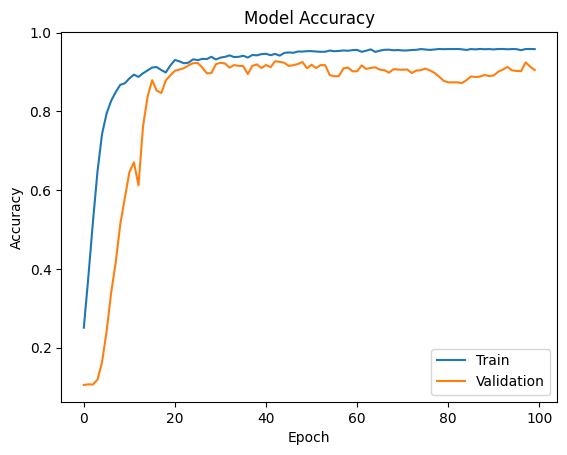

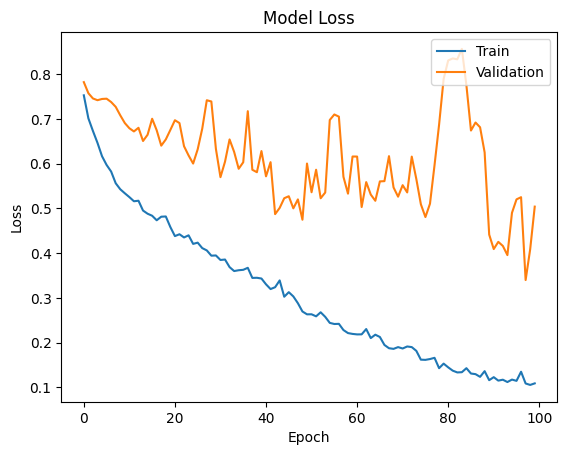

In [170]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [171]:
model.save("./dist/U_net_cup_mask.keras")
model.save_weights("./dist/U_net_cup_mask.weights.h5")

In [172]:
test_img = cv2.imread("data/cropped/full-fundus/CRFO-v4-49.png")
test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))
test_img_list = []



test_img_list.append(test_img)

In [173]:
test_img_list = np.array(test_img_list)

In [174]:
test_img_list = test_img_list.astype("float32") / 255.0

In [175]:
test_img_list.shape

test_img_list = np.expand_dims(test_img_list, axis=0)

In [176]:
test_img_list.shape

(1, 1, 256, 256, 3)

In [177]:
mask = model.predict(test_img_list[0])

1/1 [==============================] - 1s 587ms/step


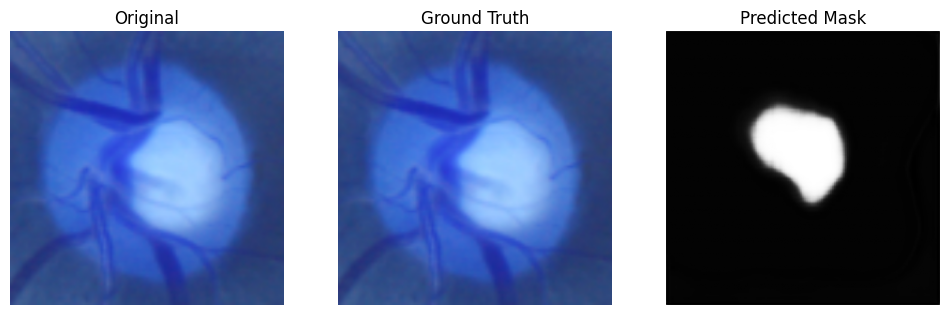

In [178]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(mask[0].squeeze(), cmap="gray")
plt.axis("off")

plt.show()